### Business Problem: To predict bank category as "Outstanding, Satisfactory or Deficient" using FTC act.

### Approach:
              1. Explored the data sets given in this problem
              2. Combined the data sets using "BankID"
              3. Understood the definition of "UFDP" and "NotUFDP" from FTC act.
              4. Explored the data given in Grievance description & clean this column
              5. Created words corpus usind FTC act
              6. Calculated TFIDF and using TFIDF, calculated sentiments
              7. Identified grievance line items as "UFDP" or "NotUFDP" using Sentiment analysis 
              8. Rolled up all grivance data to bank level
              9. Build the model and tuned the model

### Data Exploration: 1. Grievance ID: Compliant number raised by consumer
                      2. BankID: Bank for which grievance is raised
                      3. State: State to which bank belongs to
                      4. DateOfGrievance: Date on which grievance was raised
                      5. Grievance_Category: Category in which grievance falls
                      6. GrievanceDescription: Grievance description which consumer has explained
                      7. LineOfBusiness: Line of business to which grievance falls
                      8. ResolutionComments: Resolution address
                      9. Disputed: Disputed by consumer or not
                     10. DateOfResolution: Date on which grievance is resolved
                     11. BankGrade: Bank Category
                        
### Business Insights 

When customers contact you directly with complaints, hear them out. They may be offering insights into what your company can do to win back their loyalty.so in this problem we find the important attribute and tell them to client please keep these attribute and remove irrelevant attribute.
                      
                      
                      
                      
                      










### import libraries

In [1]:
# General
import numpy as np  ### Scientific Computation
import pandas as pd ### Dataframes
import nltk  ### Natural Language Processing
import random
import os       ### path directory manipulation
from os import path
from PIL import Image  ### image saving
import dateparser
from ipywidgets import widgets

# Visualization
import matplotlib as mpl       ### plot
import matplotlib.pyplot as plt
import seaborn as sns         ### simple graphics
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS   ### text frequency visualization
# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])
# Alternate # plt.style.use('fivethirtyeight')

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

# Modeling
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
#from gensim.models import word2vec
# Warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\DELL\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


#### load the data

In [2]:
# Read and Import the data
Grievances = pd.read_csv("GrievancesData_Train.csv")
Train=pd.read_csv("Train.csv")

In [3]:
Grievances_df=Train.merge(Grievances)

In [4]:
#### see some rows
Grievances.head()

,Unnamed: 0,BankID,BankGrade,GrievanceID,State,DateOfGrievance,Grievance_Category,GrievanceDescription,LineOfBusiness,ResolutionComments,Disputed,DateOfResolution,days,sentiment,Ufdp_Category
0,0,Bank5298,satisfactory,GID347643,State53,2012-04-02,Taking out the loan or lease,life purchased car advised dealership texas cp...,Consumer Loan,Closed with explanation,No,2012-04-18,16,-0.148571,0
1,1,Bank5298,satisfactory,GID353199,State53,2012-05-11,Taking out the loan or lease,vehicle live purchased vehicle arrived without...,Consumer Loan,Closed with explanation,No,2012-06-07,27,0.075779,1
2,2,Bank5298,satisfactory,GID353312,State53,2012-05-11,Taking out the loan or lease,vehicle live purchased vehicle arrived without...,Consumer Loan,Closed with explanation,No,2012-06-07,27,0.075779,1
3,3,Bank5298,satisfactory,GID353497,State9,2012-05-12,Managing the loan or lease,car bank5298and went vehicle almost 3 year cha...,Consumer Loan,Closed with explanation,Yes,2012-06-04,23,-0.130000,0
4,4,Bank5298,satisfactory,GID357567,State14,2012-06-08,Managing the loan or lease,purchase vehicle xxxxmy salesperson financial ...,Consumer Loan,Closed with explanation,Yes,2012-07-02,24,-0.192708,0


In [5]:
#### see all columns name
Grievances_df.columns

Index(['BankID', 'BankGrade', 'Unnamed: 0', 'GrievanceID', 'State',
       'DateOfGrievance', 'Grievance_Category', 'GrievanceDescription',
       'LineOfBusiness', 'ResolutionComments', 'Disputed', 'DateOfResolution',
       'days', 'sentiment', 'Ufdp_Category'],
      dtype='object')

##### check null values

In [6]:
## check null values
Grievances_df.isna().sum()

BankID                  0
BankGrade               0
Unnamed: 0              0
GrievanceID             0
State                   0
DateOfGrievance         0
Grievance_Category      0
GrievanceDescription    0
LineOfBusiness          0
ResolutionComments      0
Disputed                0
DateOfResolution        0
days                    0
sentiment               0
Ufdp_Category           0
dtype: int64

##### impute null values by mode

In [7]:
Grievances_df = Grievances_df.fillna(Grievances_df["State"].value_counts().index[0])
Grievances_df.isnull().sum()

BankID                  0
BankGrade               0
Unnamed: 0              0
GrievanceID             0
State                   0
DateOfGrievance         0
Grievance_Category      0
GrievanceDescription    0
LineOfBusiness          0
ResolutionComments      0
Disputed                0
DateOfResolution        0
days                    0
sentiment               0
Ufdp_Category           0
dtype: int64

# EDA (Exploratry data analysis)

##### 1. Let's create a few variables from the date variable for analysis. Does the number of Grievances increases every year? Is there a particular month when consumers are more likely to file for grievances?



In [8]:
Grievances['year'] = Grievances['DateOfGrievance'].map(lambda x: x.split("-")[0])
Grievances['month'] = Grievances['DateOfGrievance'].map(lambda x: x.split("-")[1])

In [9]:
Grievances.year.head()

0    2012
1    2012
2    2012
3    2012
4    2012
Name: year, dtype: object

In [10]:
Grievances.year.unique()

array(['2012', '2013', '2014', '2016', '2015'], dtype=object)

#### 2. Distribution of Grievances by year(-2017)

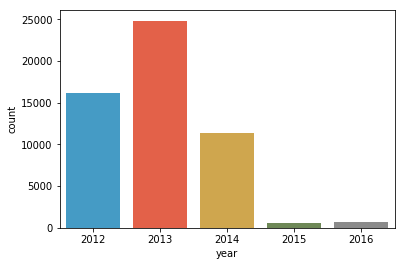

In [11]:
sns.countplot(x='year', data = Grievances[Grievances["year"]!='2017'])

##### There is steady decrease in number of grievances over the years. This can be attributed to two likely reasons:

#### 1.More and more consumers are getting aware of this platform and using it to resolve their complaints.
##### 2.The number of consumers availing these line of business(products) has increased.

## 3 plot grievances by month

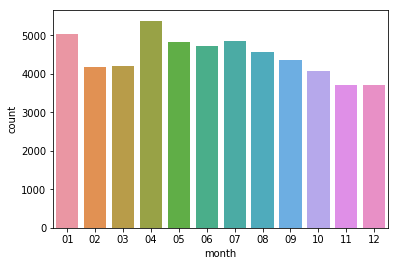

In [12]:
sns.countplot(x="month", data=Grievances)

#### Number of Grievances in each month does not differ much
#### 4. Let's explore the variable Line of Business.

In [13]:
Line_of_business = Grievances.LineOfBusiness.unique()
print(len(Line_of_business), Line_of_business)

4 ['Consumer Loan' 'Mortgage' 'Credit card' 'Student loan']


#### Distribution of Grievances by Line of business

Text(0,0.5,'Count')

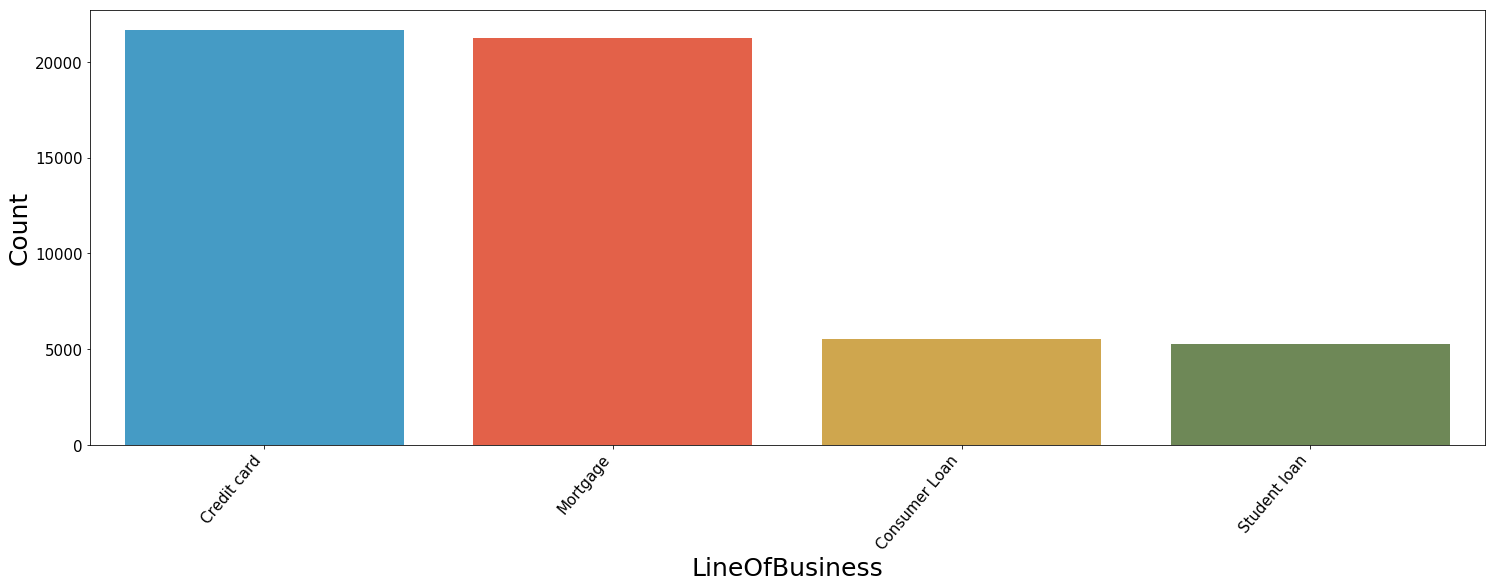

In [14]:
plt.figure(figsize = (25,8))
plt.xticks(rotation=50, fontsize=15, ha="right")
plt.yticks(fontsize=15)
g = sns.countplot(x='LineOfBusiness', data = Grievances,  order = Grievances["LineOfBusiness"].value_counts().index)
g.set_xlabel("LineOfBusiness", fontsize=25)
g.set_ylabel("Count", fontsize=25)

##### 5. Resolution comments
#### What are responses given by bank to consumers? Does a bank is more likely to respond in a paritcular way?

Text(0,0.5,'Count')

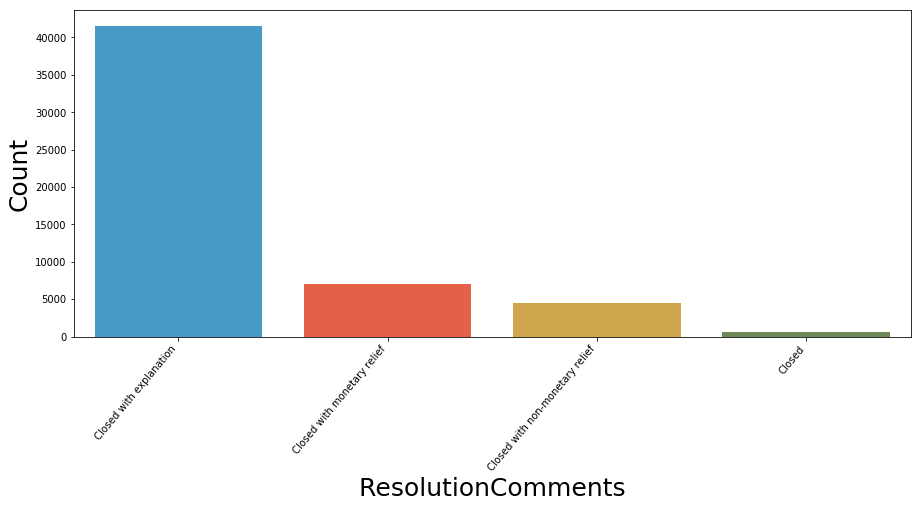

In [15]:
# what was the ResolutionComments
plt.figure(figsize = (15,6))
plt.xticks(rotation="50", ha="right", size = 10)
g = sns.countplot(x ="ResolutionComments", data = Grievances, 
                  order = Grievances['ResolutionComments'].value_counts().index)
g.set_xlabel("ResolutionComments", fontsize=25)
g.set_ylabel("Count", fontsize=25)

##### Most of complaints are closed with explanation without any monetory or non-monetary relief. So, if you have a monetary dispute good luck getting that money back.

### 6. Bank against whom these complaints have been filed:
#### Let's check the companies against whom consumers have filed these complaints.

In [16]:
Banks = Grievances.groupby('BankID').BankID.count().sort_values(ascending=False)
print(len(Banks))
Banks.head()

86


BankID
Bank5286    5623
Bank5257    5218
Bank5382    3882
Bank5285    3674
Bank5454    2228
Name: BankID, dtype: int64

#### Worst 15 Banks ranked by number of consumer complaints

Text(0,0.5,'Count')

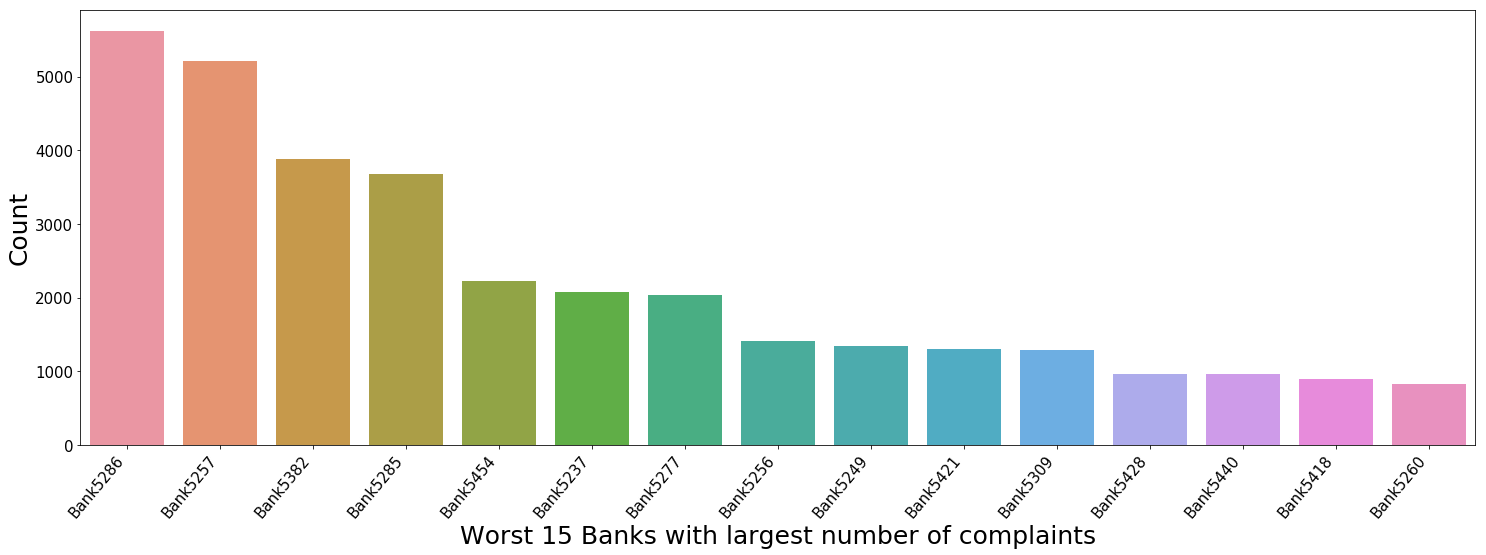

In [17]:
# top 15 Banks with largest number of complaints.
plt.figure(figsize = (25,8))
plt.xticks(rotation=50, fontsize=15, ha="right")
plt.yticks(fontsize=15)
g = sns.barplot(Banks.index[0:15], Banks.values[0:15])
g.set_xlabel("Worst 15 Banks with largest number of complaints", fontsize=25)
g.set_ylabel("Count", fontsize=25)

##### 7. Let's check the Line of Business and Grievance category related to each of worst 6 Banks


In [18]:
from ipywidgets import widgets, interact, interactive

c = widgets.ToggleButtons(
    options= Banks.index[0:6],
    description='Line_of_business:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     icons=['check'] * 3
)

@interact(BankID = c)
def plot_Banks(BankID="Bank5286, Bank5257"):
    Grievance_Category_issue = (Grievances[Grievances['BankID']==BankID].groupby("Grievance_Category").
                                Grievance_Category.count().sort_values(ascending=False)[0:10])
    plt.figure(figsize = (15,8))
    plt.xticks(rotation=50, fontsize=15, ha="right")
    plt.yticks(fontsize=15)
    g = sns.barplot( Grievance_Category_issue.index, Grievance_Category_issue.values)
    g.set_xlabel("Grievance_Category_issue".format(BankID=BankID), fontsize=25)
    g.set_ylabel("Count", fontsize=25)

interactive(children=(ToggleButtons(description='Line_of_business:', options=('Bank5286', 'Bank5257', 'Bank538…

In [19]:
c = widgets.ToggleButtons(
    options= Banks.index[0:6],
    description='Line_of_business:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     icons=['check'] * 3
)

@interact(BankID = c)
def plot_Banks(BankID="Bank5286, Bank5257"):
    Grievance_Category_issue = (Grievances[Grievances['BankID']==BankID].groupby("Grievance_Category").
                                Grievance_Category.count().sort_values(ascending=False)[0:10])
    plt.figure(figsize = (15,8))
    plt.xticks(rotation=50, fontsize=15, ha="right")
    plt.yticks(fontsize=15)
    g = sns.countplot(x ="ResolutionComments", 
                      data = Grievances[Grievances.BankID==BankID],
                      order = Grievances[Grievances.BankID==BankID]["ResolutionComments"].value_counts().index)
    g.set_xlabel("ResolutionComments".format(BankID = BankID), fontsize=25)
    g.set_ylabel("Count", fontsize=25)

interactive(children=(ToggleButtons(description='Line_of_business:', options=('Bank5286', 'Bank5257', 'Bank538…

##### 8 Bank Grade Classification

Text(0,0.5,'Count')

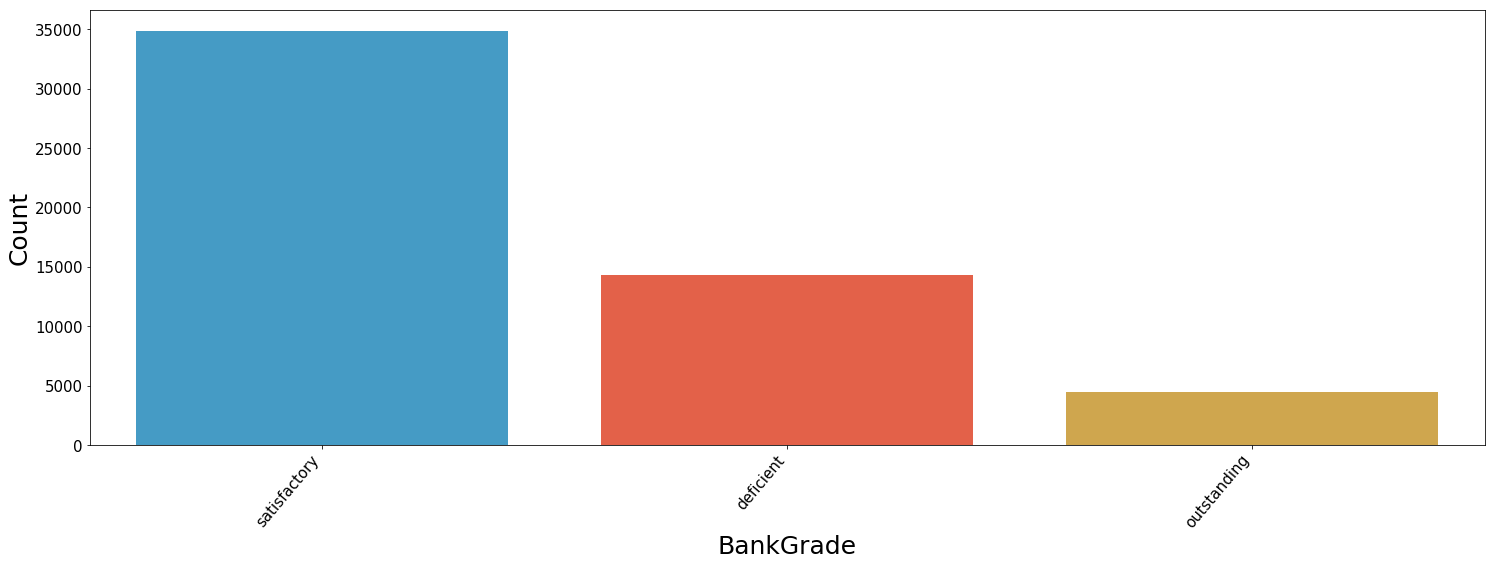

In [20]:
plt.figure(figsize = (25,8))
plt.xticks(rotation=50, fontsize=15, ha="right")
plt.yticks(fontsize=15)
g = sns.countplot(x='BankGrade', data = Grievances_df,  order = Grievances_df["BankGrade"].value_counts().index)
g.set_xlabel("BankGrade", fontsize=25)
g.set_ylabel("Count", fontsize=25)

#### Lets do a small feature engineering by creating a new column called Days which will have the number of days Grievances was resolved.

###### Days =  DateOfGrievance- DateOfResolution


In [21]:
for dataset in [Grievances_df]:
    dataset['DateOfGrievance'] = pd.to_datetime(dataset['DateOfGrievance']) 
    dataset['DateOfResolution'] = pd.to_datetime(dataset['DateOfResolution']) 
    dataset['days'] = dataset['DateOfResolution'] - dataset['DateOfGrievance'] 
    dataset['days']= dataset['days'].dt.days

In [22]:
Grievances_df.days.value_counts()

11     29125
22      9304
31      2933
12      1449
46      1344
13      1274
14       986
15       935
16       694
24       545
23       523
17       415
25       405
26       385
27       275
18       240
33       190
28       185
21       181
32       171
34       126
35       124
29       117
19       110
20        99
36        99
30        91
48        88
47        87
50        80
       ...  
1          2
171        2
127        2
629        2
8          2
205        2
78         2
198        1
314        1
94         1
96         1
139        1
93         1
554        1
202        1
98         1
162        1
281        1
113        1
134        1
99         1
10         1
121        1
89         1
120        1
83         1
72         1
211        1
116        1
86         1
Name: days, Length: 117, dtype: int64

In [23]:
Grievances_df.drop('DateOfGrievance', inplace = True, axis = 1)
Grievances_df.drop('DateOfResolution', inplace = True, axis = 1)

### Basic Feature Extraction

#### 1.Number of Words
##### One of the most basic features we can extract is the number of words in each GrievancesDescription. The basic intuition behind this is that generally, the negative sentiments contain a lesser amount of words than the positive ones.

#### To do this, we simply use the split function in python:

In [24]:
Grievances_df['word_count'] = Grievances_df['GrievanceDescription'].apply(lambda x: len(str(x).split(" ")))
Grievances_df[['GrievanceDescription','word_count']].head()

,GrievanceDescription,word_count
0,life purchased car advised dealership texas cp...,124
1,vehicle live purchased vehicle arrived without...,117
2,vehicle live purchased vehicle arrived without...,117
3,car bank5298and went vehicle almost 3 year cha...,36
4,purchase vehicle xxxxmy salesperson financial ...,123


##### 2 Number of characters
#### This feature is also based on the previous feature intuition. Here, we calculate the number of characters in each GrievancesDescription. This is done by calculating the length of the GrievancesDescription.

In [25]:
Grievances_df['char_count'] = Grievances_df['GrievanceDescription'].str.len() ## this also includes spaces
Grievances_df[['GrievanceDescription','char_count']].head()

,GrievanceDescription,char_count
0,life purchased car advised dealership texas cp...,866
1,vehicle live purchased vehicle arrived without...,812
2,vehicle live purchased vehicle arrived without...,812
3,car bank5298and went vehicle almost 3 year cha...,225
4,purchase vehicle xxxxmy salesperson financial ...,887


##### 3 Average Word Length
#### We will also extract another feature which will calculate the average word length of each GrievancesDescription. This can also potentially help us in improving our model.

##### Here, we simply take the sum of the length of all the words and divide it by the total length of the GrievancesDescription:

In [26]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

Grievances_df['avg_word'] = Grievances_df['GrievanceDescription'].apply(lambda x: avg_word(x))
Grievances_df[['GrievanceDescription','avg_word']].head()

,GrievanceDescription,avg_word
0,life purchased car advised dealership texas cp...,5.991935
1,vehicle live purchased vehicle arrived without...,5.948718
2,vehicle live purchased vehicle arrived without...,5.948718
3,car bank5298and went vehicle almost 3 year cha...,5.277778
4,purchase vehicle xxxxmy salesperson financial ...,6.219512


#### 4 Number of stopwords
###### Generally, while solving an NLP problem, the first thing we do is to remove the stopwords. But sometimes calculating the number of stopwords can also give us some extra information which we might have been losing before.

###### Here, we have imported stopwords from NLTK, which is a basic NLP library in python.

In [27]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

Grievances_df['stopwords'] = Grievances_df['GrievanceDescription'].apply(lambda x: len([x for x in x.split() if x in stop]))
Grievances_df[['GrievanceDescription','stopwords']].head()

,GrievanceDescription,stopwords
0,life purchased car advised dealership texas cp...,0
1,vehicle live purchased vehicle arrived without...,0
2,vehicle live purchased vehicle arrived without...,0
3,car bank5298and went vehicle almost 3 year cha...,0
4,purchase vehicle xxxxmy salesperson financial ...,0


###### 5 Number of special characters
###### One more interesting feature which we can extract from a  GrievancesDescriptionis calculating the number of hashtags or mentions present in it. This also helps in extracting extra information from our text data.

##### Here, we make use of the ‘starts with’ function because hashtags (or mentions) always appear at the beginning of a word.

In [28]:
Grievances_df['hastags'] = Grievances_df['GrievanceDescription'].apply(lambda x: len([x for x in x.split() if x.startswith('/')]))
Grievances_df[['GrievanceDescription','hastags']].head()

,GrievanceDescription,hastags
0,life purchased car advised dealership texas cp...,0
1,vehicle live purchased vehicle arrived without...,0
2,vehicle live purchased vehicle arrived without...,0
3,car bank5298and went vehicle almost 3 year cha...,0
4,purchase vehicle xxxxmy salesperson financial ...,0


##### 6.Number of numerics
##### Just like we calculated the number of words, we can also calculate the number of numerics which are present in the GrievancesDescription. 

In [29]:
Grievances_df['numerics'] = Grievances_df['GrievanceDescription'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
Grievances_df[['GrievanceDescription','numerics']].head()

,GrievanceDescription,numerics
0,life purchased car advised dealership texas cp...,1
1,vehicle live purchased vehicle arrived without...,0
2,vehicle live purchased vehicle arrived without...,0
3,car bank5298and went vehicle almost 3 year cha...,2
4,purchase vehicle xxxxmy salesperson financial ...,2


##### 7 Number of Uppercase words
#####  writing in UPPERCASE words which makes this a necessary operation to identify those words.

In [30]:
Grievances_df['upper'] = Grievances_df['GrievanceDescription'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
Grievances_df[['GrievanceDescription','upper']].head()

,GrievanceDescription,upper
0,life purchased car advised dealership texas cp...,0
1,vehicle live purchased vehicle arrived without...,0
2,vehicle live purchased vehicle arrived without...,0
3,car bank5298and went vehicle almost 3 year cha...,0
4,purchase vehicle xxxxmy salesperson financial ...,0


In [31]:
### remove unwanted column these column created for visualization time for more insights
Grievances_df.drop('Unnamed: 0', inplace = True, axis = 1)
Grievances_df.drop('State', inplace = True, axis = 1)
Grievances_df.drop('word_count', inplace = True, axis = 1)
Grievances_df.drop('char_count', inplace = True, axis = 1)
Grievances_df.drop('avg_word', inplace = True, axis = 1)
Grievances_df.drop('stopwords', inplace = True, axis = 1)
Grievances_df.drop('hastags', inplace = True, axis = 1)
Grievances_df.drop('numerics', inplace = True, axis = 1)
Grievances_df.drop('upper', inplace = True, axis = 1)



## 2. Basic Pre-processing
###### So far, we have find extract basic features from text data. Before diving into text and feature extraction, our first step should be cleaning the data in order to obtain better features. We will achieve this by doing some of the basic pre-processing steps on our training data.

###### So, let’s get into it.

 

##### 1 Lower case
######  first pre-processing step which we will do is transform our  GrievancesDescription into lower case. This avoids having multiple copies of the same words. For example, while calculating the word count here, Bank and bank will be taken as different words

In [32]:
Grievances_df['GrievanceDescription'] = Grievances_df['GrievanceDescription'].apply(lambda x: " ".join(x.lower() for x in x.split()))
Grievances_df['GrievanceDescription'].head()

0    life purchased car advised dealership texas cp...
1    vehicle live purchased vehicle arrived without...
2    vehicle live purchased vehicle arrived without...
3    car bank5298and went vehicle almost 3 year cha...
4    purchase vehicle xxxxmy salesperson financial ...
Name: GrievanceDescription, dtype: object

##### 2 Removing Punctuation
##### The next step is to remove punctuation, as it doesn’t add any extra information while treating text data. Therefore removing all instances of it will help us reduce the size of the training data.

In [33]:
Grievances_df['GrievanceDescription'] = Grievances_df['GrievanceDescription'].str.replace('[^\w\s]','')
Grievances_df['GrievanceDescription'].head()

0    life purchased car advised dealership texas cp...
1    vehicle live purchased vehicle arrived without...
2    vehicle live purchased vehicle arrived without...
3    car bank5298and went vehicle almost 3 year cha...
4    purchase vehicle xxxxmy salesperson financial ...
Name: GrievanceDescription, dtype: object

###### 3 Removal of Stop Words
######  stop words (or commonly occurring words) should be removed from the text data. For this purpose, we can either create a list of stopwords ourselves or we can use predefined libraries.

In [34]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
Grievances_df['GrievanceDescription'] = Grievances_df['GrievanceDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
Grievances_df['GrievanceDescription'].head()

0    life purchased car advised dealership texas cp...
1    vehicle live purchased vehicle arrived without...
2    vehicle live purchased vehicle arrived without...
3    car bank5298and went vehicle almost 3 year cha...
4    purchase vehicle xxxxmy salesperson financial ...
Name: GrievanceDescription, dtype: object

###### 4 Frequency of word removal
###### Previously, we just removed commonly occurring words in a general sense. We can also remove commonly occurring words from our text data First, let’s check the 10 most frequently occurring words in our text data then take call to remove or retain.

In [35]:
freq = pd.Series(' '.join(Grievances_df['GrievanceDescription']).split()).value_counts()[:20]
freq

month          36106
call           29426
day            28101
year           27666
company        25557
interest       25151
letter         24875
fee            24550
paid           24536
made           24130
amount         23981
information    23955
charge         23794
home           23656
back           23566
balance        23338
late           23284
could          22899
sent           22463
said           22151
dtype: int64

###### Now, let’s remove these words as their presence will not of any use in classification of our text data.

In [36]:
freq = list(freq.index)
Grievances_df['GrievanceDescription'] = Grievances_df['GrievanceDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
Grievances_df['GrievanceDescription'].head()


0    life purchased car advised dealership texas cp...
1    vehicle live purchased vehicle arrived without...
2    vehicle live purchased vehicle arrived without...
3    car bank5298and went vehicle almost 3 charging...
4    purchase vehicle xxxxmy salesperson financial ...
Name: GrievanceDescription, dtype: object

##### 5 Rare words removal
##### Similarly, just as we removed the most common words, this time let’s remove rarely occurring words from the text. Because they’re so rare, the association between them and other words is dominated by noise. You can replace rare words with a more general form and then this will have higher counts

In [37]:
freq = pd.Series(' '.join(Grievances_df['GrievanceDescription']).split()).value_counts()[-10:]
freq

provideprinted    1
2955              1
creted            1
secmailre         1
tress             1
thedocuments      1
whittled          1
anotherthey       1
rphone            1
equite            1
dtype: int64

In [38]:
freq = list(freq.index)
Grievances_df['GrievanceDescription'] = Grievances_df['GrievanceDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
Grievances_df['GrievanceDescription'].head()

0    life purchased car advised dealership texas cp...
1    vehicle live purchased vehicle arrived without...
2    vehicle live purchased vehicle arrived without...
3    car bank5298and went vehicle almost 3 charging...
4    purchase vehicle xxxxmy salesperson financial ...
Name: GrievanceDescription, dtype: object

##### All these pre-processing steps are essential and help us in reducing our vocabulary clutter so that the features produced in the end are more effective.

##### 6 Spelling correction
###### spelling correction is a useful pre-processing step because this also will help us in reducing multiple copies of words

In [39]:
from textblob import TextBlob
Grievances_df['GrievanceDescription'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    life purchased car advised leadership texas ca...
1    vehicle live purchased vehicle arrived without...
2    vehicle live purchased vehicle arrived without...
3    car bank5298and went vehicle almost 3 charging...
4    purchase vehicle xxxxmy salesperson financial ...
Name: GrievanceDescription, dtype: object

##### 7 Tokenization
#### Tokenization refers to dividing the text into a sequence of words or sentences. In our example, we have used the textblob library to first transform our tweets into a blob and then converted them into a series of words.

In [40]:
TextBlob(Grievances_df['GrievanceDescription'][1]).words

WordList(['vehicle', 'live', 'purchased', 'vehicle', 'arrived', 'without', 'temporary', 'plate', 'asked', 'dealership', 'plate', 'blew', 'transport', 'transport', 'driver', 'stated', 'plate', 'picked', 'financed', 'bank5298', 'fined', 'ftc', 'several', 'vehicle', 'dealership', 'send', 'title', 'registration', 'got', 'involved', 'apparently', 'dealer', 'car', 'purchased', 'cps', 'knew', 'accepted', 'cps', 'dealer', 'state', 'failed', 'perfect', 'lien', 'within', 'cps', 'demanding', 'return', 'monies', 'dealer', 'informed', 'cps', 'defaulted', 'note', 'missed', 'car', 'extra', 'make', 'missed', 'dealer', 'telling', 'repossessing', 'vehicle', 'default', 'cps', 'colluded', 'dealer', 'commit', 'fraud', 'knew', 'dealer', 'car', 'agreed', 'accept', 'car', 'repossessed', 'note', 'cps', 'fined', 'ftc', 'type', 'practice', 'losing', 'money', 'invested', 'several', 'attempt', 'contact', 'cps', 'regarding', 'problem', 'put', 'right', 'manager', 'need', 'someone', 'contact', 'lose', 'car', 'dealer'

###### 8 Stemming
##### Stemming refers to the removal of suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach. For this purpose, we will use PorterStemmer from the NLTK library.

In [41]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
Grievances_df['GrievanceDescription'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0    life purchas car advis dealership texa cp fina...
1    vehicl live purchas vehicl arriv without tempo...
2    vehicl live purchas vehicl arriv without tempo...
3    car bank5298and went vehicl almost 3 charg alo...
4    purchas vehicl xxxxmi salesperson financi pers...
Name: GrievanceDescription, dtype: object

##### 9 Lemmatization
###### Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices. It makes use of the vocabulary and does a morphological analysis to obtain the root word. Therefore, we usually prefer using lemmatization over stemming.

In [42]:
from textblob import Word
Grievances_df['GrievanceDescription'] = Grievances_df['GrievanceDescription'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
Grievances_df['GrievanceDescription'].head()

0    life purchased car advised dealership texas cp...
1    vehicle live purchased vehicle arrived without...
2    vehicle live purchased vehicle arrived without...
3    car bank5298and went vehicle almost 3 charging...
4    purchase vehicle xxxxmy salesperson financial ...
Name: GrievanceDescription, dtype: object

## 3. Advance Text Processing
###### Up to this point, we have done all the basic pre-processing steps in order to clean our data. Now, we can finally move on to extracting features using NLP techniques.

#### 1 N-grams
##### N-grams are the combination of multiple words used together.Unigrams do not usually contain as much information as compared to bigrams and trigrams. The basic principle behind n-grams is that they capture the language structure, like what letter or word is likely to follow the given one. 

In [43]:
TextBlob(Grievances_df['GrievanceDescription'][0]).ngrams(2)

[WordList(['life', 'purchased']),
 WordList(['purchased', 'car']),
 WordList(['car', 'advised']),
 WordList(['advised', 'dealership']),
 WordList(['dealership', 'texas']),
 WordList(['texas', 'cps']),
 WordList(['cps', 'financing']),
 WordList(['financing', 'car']),
 WordList(['car', 'today']),
 WordList(['today', 'yet']),
 WordList(['yet', 'receive']),
 WordList(['receive', 'documentation']),
 WordList(['documentation', 'cps']),
 WordList(['cps', 'however']),
 WordList(['however', 'today']),
 WordList(['today', 'receive']),
 WordList(['receive', 'dept']),
 WordList(['dept', 'collection']),
 WordList(['collection', 'knew']),
 WordList(['knew', 'date']),
 WordList(['date', 'dealership']),
 WordList(['dealership', 'certain']),
 WordList(['certain', 'actual']),
 WordList(['actual', 'monthly']),
 WordList(['monthly', 'wife']),
 WordList(['wife', 'scanned']),
 WordList(['scanned', 'emailed']),
 WordList(['emailed', 'copy']),
 WordList(['copy', 'receipt']),
 WordList(['receipt', 'complete'])

###### 2 Term frequency
###### Term frequency is simply the ratio of the count of a word present in a sentence, to the length of the sentence.

###### Therefore, we can generalize term frequency as:

##### TF = (Number of times term T appears in the particular row) / (number of terms in that row)

In [44]:
tf1 = (Grievances_df['GrievanceDescription'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,cps,8
1,dealer,7
2,car,5
3,vehicle,4
4,contact,3
5,plate,3
6,need,2
7,purchased,2
8,fraud,2
9,knew,2


##### 3 Inverse Document Frequency
##### IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.
######  IDF of each word is the log of the ratio of the total number of rows to the number of rows in which that word is present.

In [45]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(Grievances_df.shape[0]/(len(Grievances_df[Grievances_df['GrievanceDescription'].str.contains(word)])))

tf1

,words,tf,idf
0,cps,8,7.201916
1,dealer,7,4.088401
2,car,5,1.559566
3,vehicle,4,3.379818
4,contact,3,1.386742
5,plate,3,5.907189
6,need,2,1.433830
7,purchased,2,2.800700
8,fraud,2,2.140271
9,knew,2,3.536433


###### 4 Term Frequency – Inverse Document Frequency (TF-IDF)

In [46]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,cps,8,7.201916,57.615331
1,dealer,7,4.088401,28.618807
2,car,5,1.559566,7.797830
3,vehicle,4,3.379818,13.519272
4,contact,3,1.386742,4.160225
5,plate,3,5.907189,17.721567
6,need,2,1.433830,2.867659
7,purchased,2,2.800700,5.601400
8,fraud,2,2.140271,4.280542
9,knew,2,3.536433,7.072867


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(Grievances_df['GrievanceDescription'])

train_vect

<53680x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2049506 stored elements in Compressed Sparse Row format>

##### 5 Bag of Words
##### Bag of Words (BoW) refers to the representation of text which describes the presence of words within the text data. The intuition behind this is that two similar text fields will contain similar kind of words, and will therefore have a similar bag of words

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(Grievances_df['GrievanceDescription'])
train_bow

<53680x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 2343924 stored elements in Compressed Sparse Row format>

#### make a own bag of word or corpus using grievance description or ftca act pdf file

In [49]:
add_bag_of_words = ["unfair","deceptive","omission","misleading","commit","reprocessing","invested","secured","progress","late","dealership","review","report","violation"] 

###### 6 Sentiment Analysis

In [50]:
Grievances_df['GrievanceDescription'][:5].apply(lambda x: TextBlob(x).sentiment)

0     (-0.16938775510204082, 0.46020408163265303)
1      (0.07577922077922077, 0.42214285714285715)
2      (0.07577922077922077, 0.42214285714285715)
3    (-0.016666666666666663, 0.35000000000000003)
4      (-0.2202380952380952, 0.48333333333333334)
Name: GrievanceDescription, dtype: object

 ##### Here, we only extract polarity as it indicates the sentiment as value nearer to 1 means a positive sentiment and values nearer to -1 means a negative sentiment. This can also work as a feature for building a machine learning model.

In [51]:
Grievances_df['sentiment'] = Grievances_df['GrievanceDescription'].apply(lambda x: TextBlob(x).sentiment[0] )
Grievances_df[['GrievanceDescription','sentiment']].head()

,GrievanceDescription,sentiment
0,life purchased car advised dealership texas cp...,-0.169388
1,vehicle live purchased vehicle arrived without...,0.075779
2,vehicle live purchased vehicle arrived without...,0.075779
3,car bank5298and went vehicle almost 3 charging...,-0.016667
4,purchase vehicle xxxxmy salesperson financial ...,-0.220238


### using sentiment analysis we can create a new feature Ufdp_category
##### if sentiment is negative ufdp = 0
##### not_ufdp (positive sentiment) = 1


In [52]:
Grievances_df['Ufdp_Category'] = np.where(Grievances_df['sentiment']>=0, '1', '0')

In [53]:
Grievances_df

,BankID,BankGrade,GrievanceID,Grievance_Category,GrievanceDescription,LineOfBusiness,ResolutionComments,Disputed,days,sentiment,Ufdp_Category
0,Bank5298,satisfactory,GID347643,Taking out the loan or lease,life purchased car advised dealership texas cp...,Consumer Loan,Closed with explanation,No,16,-0.169388,0
1,Bank5298,satisfactory,GID353199,Taking out the loan or lease,vehicle live purchased vehicle arrived without...,Consumer Loan,Closed with explanation,No,27,0.075779,1
2,Bank5298,satisfactory,GID353312,Taking out the loan or lease,vehicle live purchased vehicle arrived without...,Consumer Loan,Closed with explanation,No,27,0.075779,1
3,Bank5298,satisfactory,GID353497,Managing the loan or lease,car bank5298and went vehicle almost 3 charging...,Consumer Loan,Closed with explanation,Yes,23,-0.016667,0
4,Bank5298,satisfactory,GID357567,Managing the loan or lease,purchase vehicle xxxxmy salesperson financial ...,Consumer Loan,Closed with explanation,Yes,24,-0.220238,0
5,Bank5298,satisfactory,GID358743,Managing the loan or lease,debt collector bank5298 cps hung telling bad t...,Consumer Loan,Closed with explanation,No,13,-0.089286,0
6,Bank5298,satisfactory,GID359723,Problems when you are unable to pay,issue begin beginning financed blue book value...,Consumer Loan,Closed with explanation,No,14,-0.068200,0
7,Bank5298,satisfactory,GID360450,Managing the loan or lease,2015 separate phone bank5298 first est voicema...,Consumer Loan,Closed with explanation,Yes,27,-0.003571,0
8,Bank5298,satisfactory,GID360822,Managing the loan or lease,bank5298 financial applyng towards continuousl...,Consumer Loan,Closed with explanation,No,14,0.000000,1
9,Bank5298,satisfactory,GID361232,Problems when you are unable to pay,name bank5298 cps car opened unfortunately pur...,Consumer Loan,Closed with explanation,No,18,-0.167716,0


#### using word clouds to see the higher frequency words from each sentiment

In [54]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
        plt.imshow(wordcloud,interpolation='bilinear')
    return

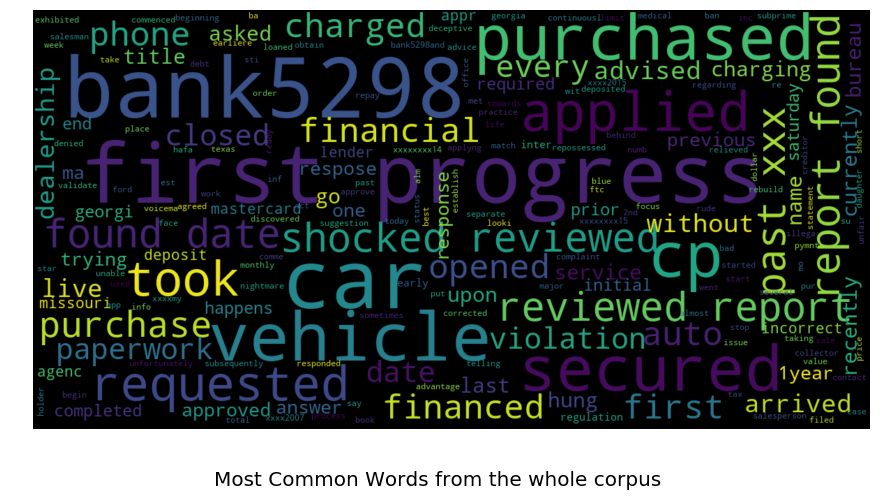

In [55]:
show_wordcloud(Grievances_df['GrievanceDescription'],'Most Common Words from the whole corpus')
plt.show()

Text(0,0.5,'Count')

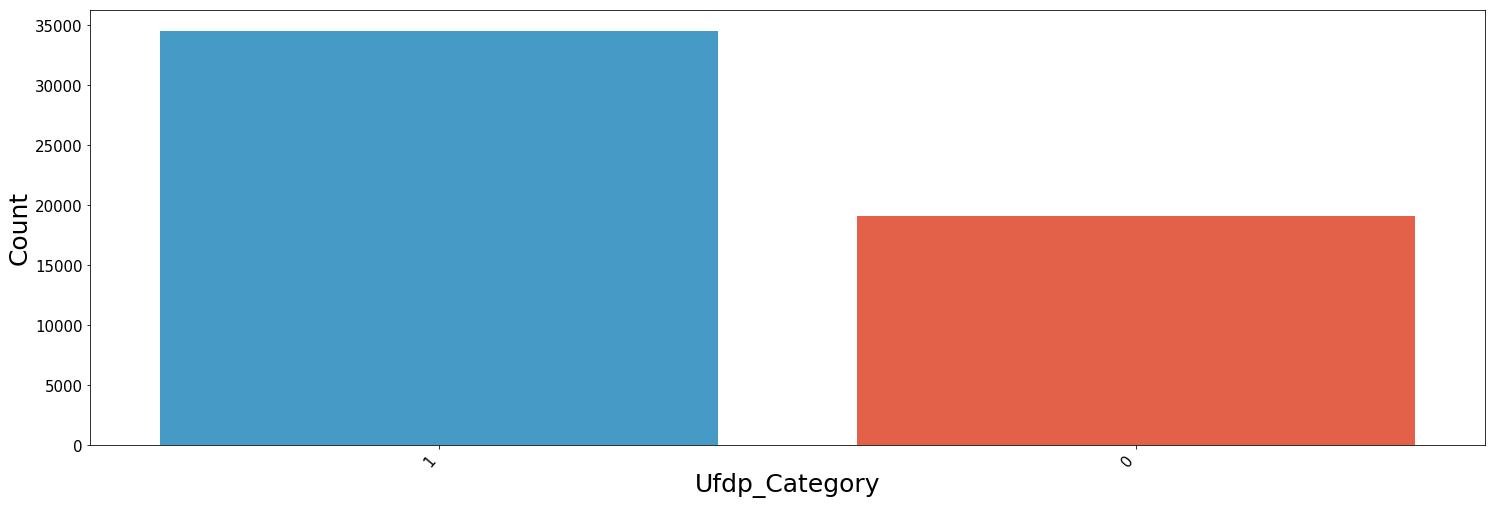

In [56]:
plt.figure(figsize = (25,8))
plt.xticks(rotation=50, fontsize=15, ha="right")
plt.yticks(fontsize=15)
g = sns.countplot(x='Ufdp_Category', data = Grievances_df,  order = Grievances_df["Ufdp_Category"].value_counts().index)
g.set_xlabel("Ufdp_Category", fontsize=25)
g.set_ylabel("Count", fontsize=25)

##### 7 using word2vec find similarites and train the model

In [57]:
import gensim
from gensim.models import Word2Vec

In [58]:
from nltk.corpus import brown

In [59]:
model = gensim.models.Word2Vec(Grievances_df['GrievanceDescription'],size=150, window=10, min_count=2, workers=10)

In [60]:
### Before model building drop irrelevant attribute
Grievances_df.drop('GrievanceID', inplace = True, axis = 1)
Grievances_df.drop('GrievanceDescription', inplace = True, axis = 1)
Grievances_df.drop('sentiment', inplace = True, axis = 1)
Grievances_df.drop('days', inplace = True, axis = 1)


In [61]:
Grievances_df.drop('Disputed', inplace = True, axis = 1)


#### after find the all cleaning into grievance description column and create a new feature ufdp or not ufdp Rollup the data into bank level because this problem is basically bank problem 

### Roll-up the data into Bank level

#### check the count value which rows are similar merge similar rows using bank id

In [62]:
Grievances_df2 = Grievances_df.groupby(['BankID', 'LineOfBusiness','Grievance_Category','ResolutionComments','Ufdp_Category','BankGrade']).size().reset_index()
Grievances_df2.columns = ['BankID', 'LineOfBusiness', 'Grievance_Category','ResolutionComments','Ufdp_Category','BankGrade','count']
Grievances_df2

,BankID,LineOfBusiness,Grievance_Category,ResolutionComments,Ufdp_Category,BankGrade,count
0,Bank5234,Student loan,Can't repay my loan,Closed with explanation,0,deficient,12
1,Bank5234,Student loan,Can't repay my loan,Closed with explanation,1,deficient,26
2,Bank5234,Student loan,Dealing with my lender or servicer,Closed with explanation,0,deficient,116
3,Bank5234,Student loan,Dealing with my lender or servicer,Closed with explanation,1,deficient,122
4,Bank5234,Student loan,Dealing with your lender or servicer,Closed with explanation,0,deficient,23
5,Bank5234,Student loan,Dealing with your lender or servicer,Closed with explanation,1,deficient,22
6,Bank5234,Student loan,Getting a loan,Closed with explanation,1,deficient,1
7,Bank5234,Student loan,Incorrect information on your report,Closed with explanation,0,deficient,2
8,Bank5234,Student loan,Incorrect information on your report,Closed with explanation,1,deficient,2
9,Bank5234,Student loan,Struggling to repay your loan,Closed with explanation,0,deficient,2


In [63]:
### after count or roll up drop count
Grievances_df2.drop('count', inplace = True, axis = 1)

In [64]:
Grievances_df2.drop('BankID', inplace = True, axis = 1)

#### split the data

In [65]:
X_df = Grievances_df2.drop('BankGrade', axis = 1)
Y = Grievances_df2['BankGrade']


### use label encoder or convert into machine format

In [66]:
from sklearn import preprocessing
lab_enc=preprocessing.LabelEncoder()
X=X_df.apply(lab_enc.fit_transform)

In [67]:
X

,LineOfBusiness,Grievance_Category,ResolutionComments,Ufdp_Category
0,3,15,1,0
1,3,15,1,1
2,3,30,1,0
3,3,30,1,1
4,3,31,1,0
5,3,31,1,1
6,3,34,1,1
7,3,37,1,0
8,3,37,1,1
9,3,61,1,0


### train and test split

In [68]:
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [69]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.25, random_state=42)

#### first start with base model

In [115]:
logmodel=LogisticRegression(multi_class='multinomial',solver='newton-cg')

In [116]:
logmodel.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [117]:
prediction_log=logmodel.predict(X_val)

In [118]:
from sklearn.metrics import classification_report

In [120]:
accuracy_score(Y_val,prediction_log)

0.6093023255813953

## Lets proceed to Machine Learning Modelling

#### Lets apply different machine learning models
##### 1.Logistic Regression
##### 2.SVM
##### 3.Random Forests
##### 4.AdaBoost
##### 5.XGBoost

In [70]:

from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, average_precision_score # Evaluation
                                                                                                             # metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC


In [71]:
# Lets stick to default Hyperparametrs as of now. We shall tune the best model
log_reg = LogisticRegression(random_state= 42)
svc = SVC(random_state= 42)
rf = RandomForestClassifier(random_state= 42)
ada = AdaBoostClassifier(random_state= 42)
xgb = XGBClassifier(random_state= 42)


In [72]:
predictors = {} # Initializing a dictionary to store training and testing data
for model in [log_reg, svc, rf, ada, xgb]: # these are our objects that we instantiated above. We loop through them
    model_name = model.__class__.__name__
    predictors[model_name]  = {}
    predictors[model_name] = cross_val_score(model, X.values, Y.values, cv = 5, scoring= 'accuracy') 
    #Scores that is returned from trainer goes to the respective predictor
    

In [73]:
#Creating a Dataframe of predictions
predictions = pd.DataFrame(predictors).T
predictions['Accuracy'] = predictions.mean(axis = 1)
predictions = predictions['Accuracy']

In [74]:
predictions

LogisticRegression        0.615404
SVC                       0.589346
RandomForestClassifier    0.574216
AdaBoostClassifier        0.579559
XGBClassifier             0.584451
Name: Accuracy, dtype: float64

#### Summary - More or less all models are giving same accuracy

### Lets move ahead with RandomForest and try two different criterion- 'Entropy' and 'Gini'

In [75]:
rf = RandomForestClassifier(n_estimators= 500, criterion='entropy',max_depth=20)
rf1 = RandomForestClassifier(n_estimators= 500, criterion='gini',max_depth=20)

In [76]:
rf1 = RandomForestClassifier(n_estimators= 1000, 
                             criterion='gini',max_depth=25)
rf1.fit(X_train, Y_train)
print(accuracy_score(Y_val,rf1.predict(X_val)))

0.5441860465116279


In [77]:
rf.fit(X_train, Y_train)
rf1.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [78]:
rf = RandomForestClassifier(n_estimators= 1000, 
                            criterion='entropy',max_depth=25)
rf.fit(X_train, Y_train)
print(accuracy_score(Y_val,rf.predict(X_val)))

0.5451162790697675


In [79]:
rf.feature_importances_

array([0.29811045, 0.46969496, 0.16351952, 0.06867507])

In [80]:
# Lets choose features that explains most of variance
imp_feat = pd.DataFrame(rf.feature_importances_, index = X.columns, 
                        columns= ['Importance'])
imp_feat['Importance'].sort_values(ascending = False).index[:4]

Index(['Grievance_Category', 'LineOfBusiness', 'ResolutionComments',
       'Ufdp_Category'],
      dtype='object')

## Lets try our luck again with imp features

In [81]:
X_train, X_val, Y_train, Y_val = train_test_split( X[imp_feat['Importance'].sort_values(ascending = False).index[:4]].values
                                                  , Y.values, test_size=0.20, random_state=42)

In [82]:
rf_imp_feat = RandomForestClassifier(n_estimators= 500, criterion='entropy',max_depth=20)
rf1_imp_feat = RandomForestClassifier(n_estimators= 500, criterion='gini',max_depth=20)

rf_imp_feat.fit(X_train, Y_train)
rf1_imp_feat.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [83]:
print(accuracy_score(Y_val,rf_imp_feat.predict(X_val)))
print(accuracy_score(Y_val,rf1_imp_feat.predict(X_val)))

0.5372093023255814
0.5430232558139535


### Lets try XGBoost with tuned hyperparamter onto important features we received from Random Forest

In [84]:
# I got this best parameters after fine tuning few of the values
Best_parameters= {'reg_lambda': 1.25, 'max_depth': 5, 'min_child_weight': 7}


'''
parameters = {'max_depth': [5,10,12,15,20],
              'min_child_weight':[2,3,4,5,7], 
              'reg_lambda': [0.50,0.75,1,1.25,1.5]} 
'''

"\nparameters = {'max_depth': [5,10,12,15,20],\n              'min_child_weight':[2,3,4,5,7], \n              'reg_lambda': [0.50,0.75,1,1.25,1.5]} \n"

In [85]:
# Optimal Parameters
MAX_DEPTH = Best_parameters['max_depth']
MIN_CHILD_WEIGHT = Best_parameters['min_child_weight']
REG_LAMDBA = Best_parameters['reg_lambda']

In [86]:
clf_post_tune = XGBClassifier(max_depth= MAX_DEPTH , n_estimators= 500, 
                              min_child_weight= MIN_CHILD_WEIGHT, reg_lambda= REG_LAMDBA)

In [87]:
clf_post_tune.fit(X_train, Y_train)

print(accuracy_score(Y_val,clf_post_tune.predict(X_val)))

0.5825581395348837


# Load test data

In [88]:
Grievancestest = pd.read_csv("GrievancesData_Test.csv")

In [89]:
Grievancestest

,Unnamed: 0,GrievanceID,BankID,State,DateOfGrievance,Grievance_Category,GrievanceDescription,LineOfBusiness,ResolutionComments,Disputed,DateOfResolution
0,0,GID512414,Bank5334,State43,2016-01-19,"Loan servicing, payments, escrow account",I currently have a mortgage with Flag star ba...,Mortgage,Closed with explanation,No,2016-01-30
1,1,GID512416,Bank5278,State16,2016-01-19,Problems when you are unable to pay,Bank5278 Auto Finance repossessed and subsequ...,Consumer Loan,Closed with explanation,No,2016-02-03
2,2,GID515121,Bank5372,State56,2016-03-19,"Loan servicing, payments, escrow account",We fell behind in our payments back in 2014 f...,Mortgage,Closed with explanation,No,2016-03-30
3,3,GID515123,Bank5372,State47,2016-03-19,"Loan servicing, payments, escrow account",My home is on XXXX parcels of land. The first...,Mortgage,Closed with explanation,No,2016-03-30
4,4,GID515124,Bank5310,State10,2016-03-19,Settlement process and costs,We mortgaged our home with XXXX on XXXX/XXXX/...,Mortgage,Closed with explanation,No,2016-03-30
5,5,GID512420,Bank5259,State9,2016-01-19,Advertising and marketing,I accepted a credit card off for the Barclays...,Credit card,Closed with explanation,No,2016-01-30
6,6,GID512426,Bank5278,State40,2016-01-19,Identity theft / Fraud / Embezzlement,"I would like to be credited in full, of all t...",Credit card,Closed with explanation,No,2016-03-11
7,7,GID512428,Bank5373,State43,2016-01-19,Can't repay my loan,Can't decrease my monthly payments I am trying...,Student loan,Closed with explanation,Yes,2016-02-10
8,8,GID512429,Bank5284,State14,2016-01-19,"Loan modification,collection,foreclosure",I was charged a fee both when I spoke with XX...,Mortgage,Closed with explanation,Yes,2016-02-10
9,9,GID512430,Bank5316,State9,2016-01-19,Dealing with my lender or servicer,Having problems with customer service On XXXX ...,Student loan,Closed with explanation,No,2016-02-25


In [90]:
### drop unrelavent columns
Grievancestest.drop('Unnamed: 0', inplace = True, axis = 1)
Grievancestest.drop('State', inplace = True, axis = 1)
Grievancestest.drop('DateOfGrievance', inplace = True, axis = 1)
Grievancestest.drop('DateOfResolution', inplace = True, axis = 1)
Grievancestest.drop('Disputed', inplace = True, axis = 1)



In [91]:
Grievancestest['GrievanceDescription'][:5].apply(lambda x: TextBlob(x).sentiment)

0                 (-0.075, 0.4229166666666666)
1                  (0.0, 0.016666666666666666)
2    (-0.0666065416065416, 0.3816137566137566)
3    (0.04618055555555555, 0.4266203703703704)
4                                  (-0.2, 0.3)
Name: GrievanceDescription, dtype: object

In [92]:
Grievancestest['sentiment'] = Grievancestest['GrievanceDescription'].apply(lambda x: TextBlob(x).sentiment[0] )
Grievancestest[['GrievanceDescription','sentiment']].head()

,GrievanceDescription,sentiment
0,I currently have a mortgage with Flag star ba...,-0.075000
1,Bank5278 Auto Finance repossessed and subsequ...,0.000000
2,We fell behind in our payments back in 2014 f...,-0.066607
3,My home is on XXXX parcels of land. The first...,0.046181
4,We mortgaged our home with XXXX on XXXX/XXXX/...,-0.200000


In [93]:
Grievancestest['Ufdp_Category'] = np.where(Grievancestest['sentiment']>=0, '1', '0')

In [94]:
Grievancestest.drop('sentiment', inplace = True, axis = 1)
Grievancestest.drop('GrievanceDescription', inplace = True, axis = 1)

In [95]:
Grievancestest.drop('GrievanceID', inplace = True, axis = 1)


## roll up the test data into bank level 

In [96]:
Grievances_df3 = Grievancestest.groupby([ 'BankID','LineOfBusiness','Grievance_Category','ResolutionComments','Ufdp_Category']).size().reset_index()
Grievances_df3.columns = ['BankID','LineOfBusiness', 'Grievance_Category','ResolutionComments','Ufdp_Category','count']
Grievances_df3

,BankID,LineOfBusiness,Grievance_Category,ResolutionComments,Ufdp_Category,count
0,Bank5246,Consumer Loan,Managing the loan or lease,Closed with explanation,1,2
1,Bank5246,Consumer Loan,Managing the loan or lease,Closed with monetary relief,1,2
2,Bank5246,Consumer Loan,Managing the loan or lease,Closed with non-monetary relief,1,2
3,Bank5246,Consumer Loan,Problems when you are unable to pay,Closed with explanation,1,4
4,Bank5246,Credit card,APR or interest rate,Closed with explanation,0,20
5,Bank5246,Credit card,APR or interest rate,Closed with explanation,1,26
6,Bank5246,Credit card,APR or interest rate,Closed with monetary relief,0,3
7,Bank5246,Credit card,APR or interest rate,Closed with monetary relief,1,6
8,Bank5246,Credit card,Advertising and marketing,Closed with explanation,0,46
9,Bank5246,Credit card,Advertising and marketing,Closed with explanation,1,79


In [97]:
testbankid = pd.DataFrame(Grievances_df3['BankID'])

In [98]:
type(testbankid)

pandas.core.frame.DataFrame

In [99]:
Grievances_df3.drop('BankID', inplace = True, axis = 1)

In [100]:
from sklearn import preprocessing
lab_enc=preprocessing.LabelEncoder()
X1=Grievances_df3.apply(lab_enc.fit_transform)

In [101]:
X1.drop('count', inplace = True, axis = 1)

In [102]:
test= X1.values

In [103]:
print(X1.shape)

(1134, 4)


In [104]:
pd.DataFrame(X1)

,LineOfBusiness,Grievance_Category,ResolutionComments,Ufdp_Category
0,0,37,1,1
1,0,37,2,1
2,0,37,3,1
3,0,45,1,1
4,1,0,1,0
5,1,0,1,1
6,1,0,2,0
7,1,0,2,1
8,1,2,1,0
9,1,2,1,1


In [110]:
test_pred = logmodel.predict(X1)


In [111]:
Y_pred = pd.DataFrame(test_pred, index = X1.index, columns=['BankGrade'])
Y_pred['BankGrade'] = Y_pred['BankGrade']
Y_pred.head()

,BankGrade
0,outstanding
1,outstanding
2,outstanding
3,outstanding
4,satisfactory


In [112]:
prediction=pd.concat([testbankid,Y_pred],axis=1)
prediction.head()

,BankID,BankGrade
0,Bank5246,outstanding
1,Bank5246,outstanding
2,Bank5246,outstanding
3,Bank5246,outstanding
4,Bank5246,satisfactory


In [113]:
pred=prediction.groupby('BankID')['BankGrade'].value_counts()

In [114]:
test_result = pd.DataFrame(pred, index =pred.index, columns = ['BankGrade'])
test_result.to_csv('submission.csv', sep=',')